<a href="https://colab.research.google.com/github/nyasharunhare/Projects/blob/main/AppliedMath/AM50_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling Matchmaking on Dating Apps Using Linear Algebra  
### AM50 Final Project – Nyasha Runhare  

This notebook explores whether linear algebra can simulate compatibility on online dating platforms. Using a subset of user profile data from OkCupid and a selected set of categorical traits, we construct a user matrix and apply three models to generate and evaluate matches:

- Unweighted Dot Product  
- Weighted Dot Product  
- Weighted Trait Similarity  

We assess the models based on mutual match frequency, trait alignment, and realism of results.  
For full details, see the accompanying report.

## Loading the Dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load OkCupid dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/okcupid_profiles.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Preview the OkCupid dataset
df.head()

,age,status,sex,orientation,body_type,diet,drinks,drugs,education,ethnicity,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,22,single,m,straight,a little extra,strictly anything,socially,never,working on college/university,"asian, white",...,about me: i would love to think that i was so...,currently working as an international agent fo...,making people laugh. ranting about a good salt...,"the way i look. i am a six foot half asian, ha...","books: absurdistan, the republic, of mice and ...",food. water. cell phone. shelter.,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet! you are ti...
1,35,single,m,straight,average,mostly other,often,sometimes,working on space camp,white,...,i am a chef: this is what that means. 1. i am ...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories. my b...,NaN,NaN,i am very open and will share just about anyth...,NaN
2,38,available,m,straight,thin,anything,socially,NaN,graduated from masters program,NaN,...,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement conversation creation contemplation t...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ..."
3,23,single,m,straight,thin,vegetarian,socially,NaN,working on college/university,white,...,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . . lynch, jarmusch...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.
4,29,single,m,straight,athletic,NaN,socially,never,graduated from college/university,"asian, black, other",...,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at: http://bagsbrown....,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians at the moment...",NaN,NaN,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   status       59946 non-null  object 
 2   sex          59946 non-null  object 
 3   orientation  59946 non-null  object 
 4   body_type    54650 non-null  object 
 5   diet         35551 non-null  object 
 6   drinks       56961 non-null  object 
 7   drugs        45866 non-null  object 
 8   education    53318 non-null  object 
 9   ethnicity    54266 non-null  object 
 10  height       59943 non-null  float64
 11  income       59946 non-null  int64  
 12  job          51748 non-null  object 
 13  last_online  59946 non-null  object 
 14  location     59946 non-null  object 
 15  offspring    24385 non-null  object 
 16  pets         40025 non-null  object 
 17  religion     39720 non-null  object 
 18  sign         48890 non-null  object 
 19  smok

## Dataset Overview

This dataset contains 59 946 anonymized OkCupid profiles from the United States. It includes fields with information on demographics, lifestyle traits, education, religion and some essay responses.

I will extract and encode seven traits I think I useful when generally filtering for matches from this dataset to construct a trait matrix for compatibility modeling.

In [ ]:
selected_features = [
    'diet',
    'drinks',
    'smokes',
    'education',
    'body_type',
    'pets',
    'religion'
]

In [ ]:
# Run once to clean and save dataset
import os
drive_path = '/content/drive/My Drive/Colab Notebooks/'
file_name = 'cleaned_okcupid.csv'
save_path = os.path.join(drive_path, file_name)


if not os.path.exists(save_path):
    # Drop rows with missing values for the selected features
    df_clean = df[selected_features].dropna()

    # Convert selected features into numerical values
    for col in selected_features:
        df_clean[col] = df_clean[col].astype('category').cat.codes

    # Save cleaned dataset to new cvs file
    df_clean.to_csv(save_path, index=False)
    print(f"Saved cleaned dataset with {len(df_clean)} users to {save_path}")
else:
    print(f"Cleaned dataset already exists at {save_path}. Skipping cleaning.")


Cleaned dataset already exists at /content/drive/My Drive/Colab Notebooks/cleaned_okcupid.csv. Skipping cleaning.


In [ ]:
# Always load the dataset freshly and reset index for consistent .iloc use
df_clean = pd.read_csv(save_path)
df_clean.reset_index(drop=True, inplace=True)
print(f"Loaded cleaned dataset with {len(df_clean)} users.")

Loaded cleaned dataset with 17223 users.


## Encode Traits and Build Matrix A

Each selected trait is converted into a categorical integer code using pandas' `.astype('category').cat.codes` method. This allows us to work with a fully numeric matrix suitable for linear algebra operations.

To reduce memory usage and runtime, I limited the dataset to the first 1000 users. This subset still allows meaningful analysis while avoiding out-of-memory crashes in Colab.

Matrix $ A \in \mathbb{R}^{n \times m} $ is created, where:
- $n = 1000$  users (rows)
-  $m = 7 $ traits (columns)

In [ ]:
# Limit to first 1000 users to reduce memory usage
df_clean = df_clean.iloc[:1000].reset_index(drop=True)

# Convert DataFrame to NumPy array
A_matrix = df_clean.to_numpy()
n, m = A_matrix.shape

print(f"Reduced Matrix A shape: {A_matrix.shape}")

Reduced Matrix A shape: (1000, 7)


### Construct Compatibility Matrix (Unweighted Dot Product)

We compute the dot product between each user’s trait vector and all others to estimate compatibility. The result is a square matrix **C ∈ ℝⁿˣⁿ**, where each entry **C[i, j]** represents the compatibility score between user *i* and user *j*.

We remove user *i* from the comparison to avoid self-matching and then reinsert a placeholder (0) to maintain matrix shape.

In [ ]:
# Compute unweighted dot product compatibility matrix
C = np.zeros((n, n))  # Initialize empty matrix

for i in range(n):
    x_i = A_matrix[i]           # User i's trait preference vector
    A_minus_i = np.delete(A_matrix, i, axis=0)    # Remove user i
    b_i = A_minus_i @ x_i       # Dot product scores
    b_i = np.insert(b_i, i, 0)     # Put 0 for self-comparison
    C[i] = b_i

### Visualizing Compatibility Scores

To explore how trait similarity looks across users, we visualize the first 100 rows of the compatibility matrix **C** using a heatmap.

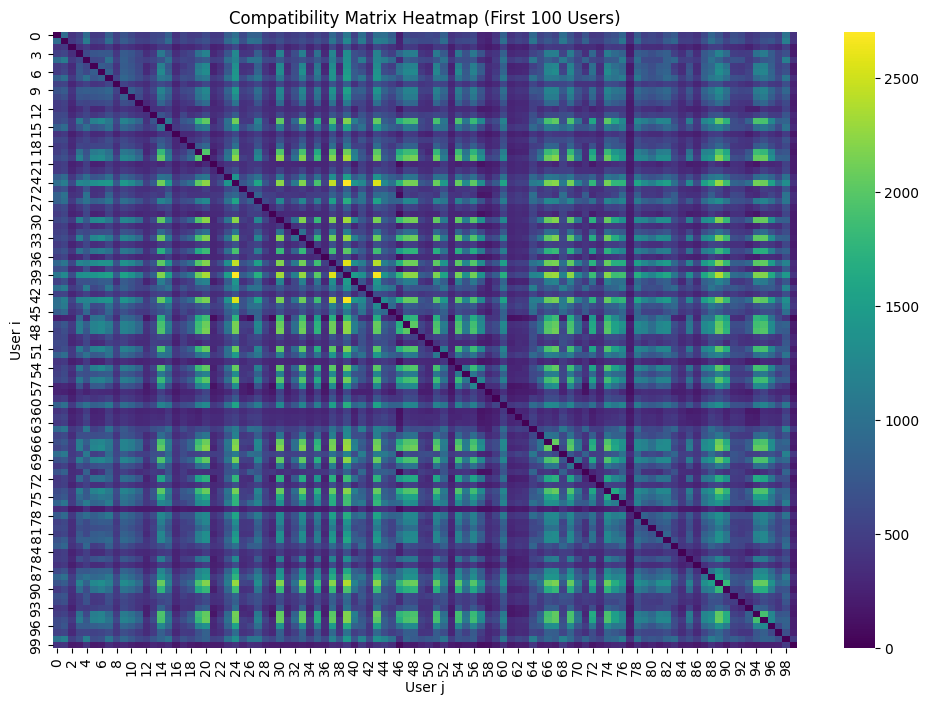

In [ ]:
# Use a small sample to avoid overloading the plot (first 100 users)
sample_C = C[:100, :100]

plt.figure(figsize=(12, 8))
sns.heatmap(sample_C, cmap='viridis')
plt.title('Compatibility Matrix Heatmap (First 100 Users)')
plt.xlabel('User j')
plt.ylabel('User i')
plt.show()

## Extracting Top Matches

Once the compatibility matrix was computed, we identified the top 10 matches for each user. These were determined by selecting the users with the highest compatibility scores, excluding self-comparisons.

We used NumPy’s `argpartition()` and `argsort()` methods for efficient partial sorting.

In [ ]:
top_k = 10
top_matches = {}

for i in range(n):
    # Get indices of top k elements using argpartition
    top_k_indices = np.argpartition(C[i], -top_k)[-top_k:]

    # Sort those top k indices in descending score order
    top_users = top_k_indices[np.argsort(-C[i][top_k_indices])]

    # Exclude self and store in top_matches
    top_matches[i] = [int(j) for j in top_users if j != i]

# Show top 10 matches for a sample user (e.g User 0)
print("Top 10 matches for User 0:", top_matches[0])

Top 10 matches for User 0: [267, 39, 493, 265, 733, 874, 964, 552, 397, 944]


**Note:** The user IDs shown here are based on the row index after data cleaning and limiting to the first 1 000 users. They may vary slightly depending on dataset filtering or runtime order.

## Identifying Mutual Matches

A mutual match is defined as a pair of users who both rank each other in their top-k lists. This double opt-in structure reflects real-world dating app logic where both users must express mutual interest.

The following code checks for mutual matches across all users and stores them as $(i, j)$ pairs.

In [ ]:
mutual_matches = []

for i in range(n):
    for j in top_matches[i]:
        if i in top_matches[j]:
            mutual_matches.append((int(i), int(j)))

# Display a few mutual matches
print("Sample mutual matches:", mutual_matches[:10])


Sample mutual matches: [(39, 299), (39, 267), (39, 513), (39, 265), (39, 932), (39, 698), (39, 874), (39, 397), (39, 733), (39, 964)]


These results represent pairs of users who are highly compatible with each other based on trait similarity. Because both users selected each other as top matches, we consider these stronger signals of compatibility.

## Visualizing Mutual Match Frequency

After computing mutual matches, we visualize how those matches are distributed across users.This helps reveal which users are broadly appealing within the network, and whether compatibility is evenly distributed or concentrated among a small group.


Length of sorted_counts: 16


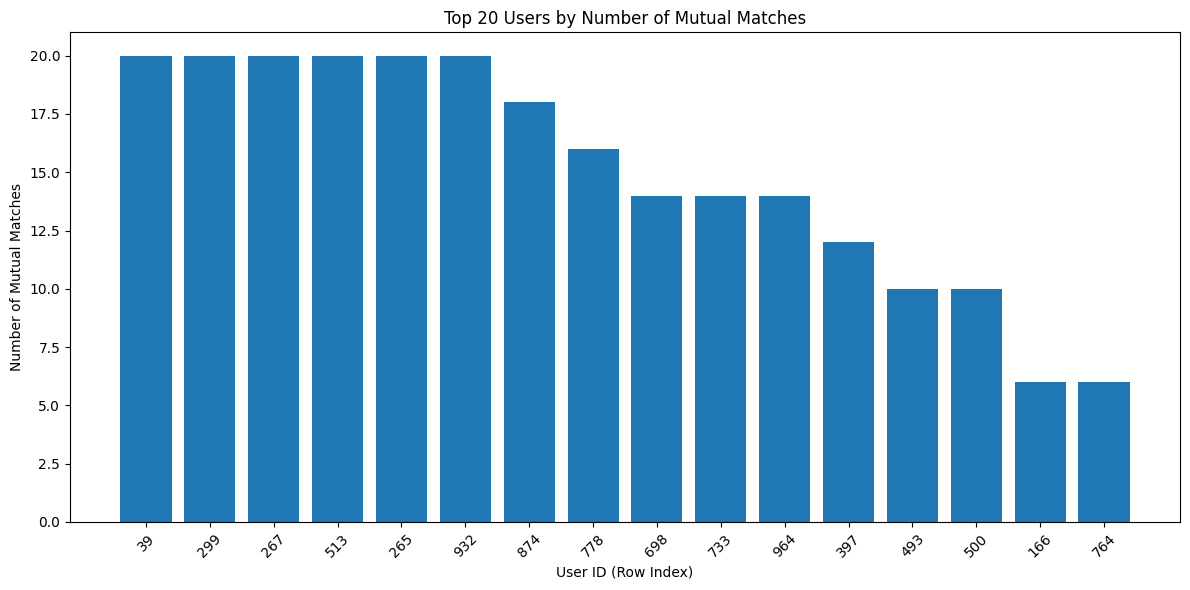

In [ ]:
# Count mutual matches per user
from collections import defaultdict

mutual_counts = defaultdict(int)

for i, j in mutual_matches:
    row_i = df_clean.index.get_loc(i)  # Get row position of user i
    row_j = df_clean.index.get_loc(j)  # Get row position of user j
    mutual_counts[row_i] += 1
    mutual_counts[row_j] += 1

# Sort mutual counts from highest to lowest
sorted_counts = sorted(mutual_counts.items(), key=lambda x: x[1], reverse=True)

# Print the length of sorted_counts
print(f"Length of sorted_counts: {len(sorted_counts)}")


# Select top 20 users
top_users = [u for u, count in sorted_counts[:20]]
top_counts = [count for u, count in sorted_counts[:20]]

# Plot mutual match frequency for top 20 users
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_users)), top_counts, tick_label=top_users)
plt.xlabel('User ID (Row Index)')
plt.ylabel('Number of Mutual Matches')
plt.title('Top 20 Users by Number of Mutual Matches')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We observe that only a small number of users appear frequently in mutual matches. This indicates that the unweighted model is highly selective so only a few users dominate the compatibility space.

In [ ]:
print(f"Total unique mutual match pairs: {len(mutual_matches)}")

Total unique mutual match pairs: 120


## Interpreting the Mutual Match Distribution

The mutual match frequency plot shows that only a small number of users appeared frequently in each other’s top-10 lists. For example, fewer than 20 users had any mutual matches at all. This reflects the selectiveness of the unweighted dot product model as it tends to reward users with high absolute trait values, making them more likely to appear in multiple users’ top lists.

This distribution supports the idea that matching is sparse and concentrated which is similar to how real dating apps tend to favor a small group of high-ranking users. However, this raises a key concern: **Are these matches actually good matches?**

In [ ]:
# Explore top matches for a specific user (user 5)
user_id = 3
print(f"Top matches for User {user_id}: {top_matches[user_id]}")

# See the profile trait values for those users
print("\nUser's own profile:")
print(df_clean.iloc[user_id])

print("\nTop match profiles:")
print(df_clean.iloc[top_matches[user_id]])

# Explore top matches for a specific user (example: user 250)
user_id = 250
print(f"Top matches for User {user_id}: {top_matches[user_id]}")

# See the profile trait values for those users
print("\nUser's own profile:")
print(df_clean.iloc[user_id])

print("\nTop match profiles:")
print(df_clean.iloc[top_matches[user_id]])

Top matches for User 3: [513, 698, 764, 265, 267, 166, 39, 874, 733, 359]

User's own profile:
diet          3
drinks        4
smokes        0
education     9
body_type     2
pets         14
religion     20
Name: 3, dtype: int64

Top match profiles:
     diet  drinks  smokes  education  body_type  pets  religion
513     3       4       0         27          4    14        44
698    14       4       1         23         10    13        44
764    10       3       0         23          5    14        44
265     3       4       2         30          2    14        42
267    16       3       0         30          3    14        40
166    10       4       0         23          1    14        44
39      8       1       0         29          2    14        42
874     3       4       0         30          5    14        41
733     3       4       1         30          2    14        41
359     3       3       0         23          5    14        44
Top matches for User 250: [267, 493, 932, 874,

## Observing Trait Mismatches in Top Matches

For User 3 and User 250, we find that their top matches often diverge significantly in key traits, particularly religion and education, which are typically considered important in dating preferences.

- User 3 has a religion value of 20, but their matches include values as high as 44.
- User 250 has religion = 4, but their matches also include users with religion codes in the 40s.
- Education scores vary widely among matches, even when the user has a moderate score (e.g 9).


One reason for this is that all traits are treated equally, and each trait is encoded with arbitrary numeric values (e.g “atheist” = 1, “Christian” = 2, “Jewish” = 3 etc). The dot product treats these as numerical quantities, even though they are unordered in meaning.


## Weighted Dot Product Model

To reflect that not all traits contribute equally to real-world compatibility, we introduce a trait weight vector. This allows us to prioritize certain traits (like religion and education) and down-weight others (like body type).

The weighted dot product model computes compatibility by scaling each user's trait vector by these weights before comparing them to others. This results in a new compatibility matrix that emphasizes alignment on more important features.


In [ ]:
# Assign weights to traits in the same order as selected_features
# For example: religion is more important, body_type less so
trait_weights = np.array([1, 1, 1, 2, 0.5, 1, 2])  # These can take whatever weights chosen

In [ ]:
# Construct the weighted compatibility matrix
C_weighted = np.zeros((n, n))

for i in range(n):
    x_i = A_matrix[i] * trait_weights    # Apply weights to preference vector
    A_minus_i = np.delete(A_matrix, i, axis=0)   # Remove self
    b_i = A_minus_i @ x_i     # Weighted dot product
    b_i = np.insert(b_i, i, 0)   # Insert 0 at self index
    C_weighted[i] = b_i

In [ ]:
# Extract top 10 matches per user from the weighted matrix
top_k = 10
top_matches_weighted = {}

for i in range(n):
    top_k_indices = np.argpartition(C_weighted[i], -top_k)[-top_k:]
    top_users = top_k_indices[np.argsort(-C_weighted[i][top_k_indices])]
    top_matches_weighted[i] = [int(j) for j in top_users if j != i]

# Show matches for User 0
print(f"Top {top_k} matches for User 0 (weighted):", top_matches_weighted[0])

Top 10 matches for User 0 (weighted): [267, 265, 733, 874, 39, 964, 397, 493, 299, 932]


### Mutual Matches : Weighted Model

We now identify mutual matches using the weighted compatibility scores. A mutual match occurs when both users rank each other in their top 10.

In [ ]:
mutual_matches_weighted = []
for i in range(n):
    for j in top_matches_weighted[i]:
        if i in top_matches_weighted[j]:
            mutual_matches_weighted.append((i, j))

print("Weighted mutual matches:", len(mutual_matches_weighted))

Weighted mutual matches: 118


We now compare mutual matches from the weighted and unweighted models to see if weighting traits reshaped the matches at all.

In [ ]:
set_unweighted = set(mutual_matches)
set_weighted = set(mutual_matches_weighted)

shared = set_unweighted & set_weighted
only_in_weighted = set_weighted - set_unweighted

print("Shared mutual matches:", len(shared))
print("Only in weighted:", len(only_in_weighted))

Shared mutual matches: 96
Only in weighted: 22


Although the total number of mutual matches changed only slightly, many of the actual pairs differed. Only 96 matches were shared across both models, and 22 new matches emerged due to trait weighting.

This shows that weighting helped reprioritize the compatibility space, emphasizing users who are more similar on key traits. Even if the total count didn't increase, the alignment of matches improved.

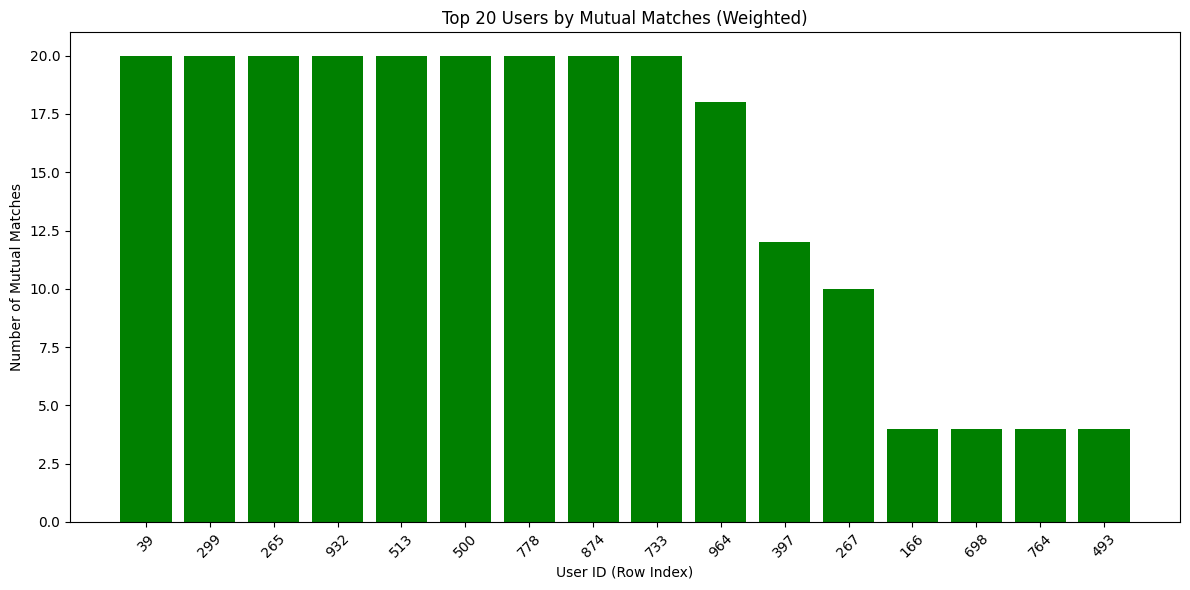

In [ ]:
# Count and plot top mutual match users (weighted model)
mutual_counts_weighted = defaultdict(int)
for i, j in mutual_matches_weighted:
    mutual_counts_weighted[i] += 1
    mutual_counts_weighted[j] += 1

# Plot
sorted_weighted = sorted(mutual_counts_weighted.items(), key=lambda x: x[1], reverse=True)
top_users_w = [u for u, count in sorted_weighted[:20]]
top_counts_w = [count for u, count in sorted_weighted[:20]]

plt.figure(figsize=(12, 6))
plt.bar(range(len(top_users_w)), top_counts_w, tick_label=top_users_w, color='green')
plt.xlabel('User ID (Row Index)')
plt.ylabel('Number of Mutual Matches')
plt.title('Top 20 Users by Mutual Matches (Weighted)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Evaluating Match Quality for Users 3 and 250 (Weighted Model)

To understand the impact of trait weighting on match quality, we review the top 10 matches for User 3 and User 250 using the weighted dot product model. While weighting improved alignment slightly, many of the top matches still differ significantly from the user in high-priority traits.

In [ ]:
user_id = 3

print(f"Top {top_k} matches for User {user_id} (weighted): {top_matches_weighted[user_id]}")
print("\nUser's own profile:")
print(df_clean.iloc[user_id])
print("\nWeighted top match profiles:")
print(df_clean.iloc[top_matches_weighted[user_id]])

user_id = 250

print(f"Top {top_k} matches for User {user_id} (weighted): {top_matches_weighted[user_id]}")
print("\nUser's own profile:")
print(df_clean.iloc[user_id])
print("\nWeighted top match profiles:")
print(df_clean.iloc[top_matches_weighted[user_id]])

Top 10 matches for User 3 (weighted): [513, 265, 299, 39, 698, 166, 764, 778, 932, 874]

User's own profile:
diet          3
drinks        4
smokes        0
education     9
body_type     2
pets         14
religion     20
Name: 3, dtype: int64

Weighted top match profiles:
     diet  drinks  smokes  education  body_type  pets  religion
513     3       4       0         27          4    14        44
265     3       4       2         30          2    14        42
299     8       1       1         30          1     8        44
39      8       1       0         29          2    14        42
698    14       4       1         23         10    13        44
166    10       4       0         23          1    14        44
764    10       3       0         23          5    14        44
778     3       3       0         28          1     9        44
932     8       4       0         29          4     9        43
874     3       4       0         30          5    14        41
Top 10 matches for User

### Trait Alignment Limitations

While weighting traits helped prioritize certain dimensions, this example illustrates a deeper modeling limitation. The profile traits used (e.g., religion and education) are encoded numerically but do not represent true ordinal or interval data. For example, a religion code of 4 vs 44 is not 10 times more different, they are just labels.

As a result, dot product similarity can misrepresent compatibility. It rewards magnitude rather than closeness which can lead to matches that look strong mathematically but feel intuitively misaligned.

This highlights a need for more thoughtful trait encoding or alternative modeling techniques. These limitations motivated the development of a final model based on weighted trait similarity, where closeness and not size determines compatibility.

## 8. Refining Compatibility with Weighted Trait Similarity

In the previous model, we used a weighted dot product, which improved the relative importance of certain traits. However, that model still rewarded large trait values, even when the users were not truly aligned.

To better capture meaningful compatibility, we implement a new model based on **weighted trait similarity**. This approach penalizes differences between users — particularly in high-weight traits — and rewards those who are closer in value.

The compatibility score is computed as:

$
\text{compatibility}(i, j) = -\sum_{k=1}^{m} w_k \cdot |A_{ik} - A_{jk}|
$

Where:
- $A_{ik}$ and $A_{jk}$ are the trait values for users $i$ and $j$ on trait $k$,
- $w_k$ is the importance weight for trait $k$.

By taking the negative sum of trait differences, this model ensures that smaller trait gaps = higher compatibility, especially for the most important features like religion and education.


In [ ]:
import numpy as np
# Define trait weights (same order as your selected features)
trait_weights = np.array([1, 1, 1, 2, 0.5, 1, 2])

# Apply weights to each user's trait vector
A_weighted = A_matrix * trait_weights

# Compute pairwise absolute weighted trait differences
diffs = np.abs(A_weighted[:, np.newaxis, :] - A_weighted[np.newaxis, :, :])

# Sum differences across traits and negate to produce similarity score
C_sim = -np.sum(diffs, axis=2)

In [ ]:
# Extract top 10 matches per user from the similarity matrix
top_k = 10
top_matches_sim = {}

for i in range(n):
    top_k_indices = np.argpartition(C_sim[i], -top_k)[-top_k:]
    top_users = top_k_indices[np.argsort(-C_sim[i][top_k_indices])]
    top_matches_sim[i] = [int(j) for j in top_users if j != i]

# Show top matches for a sample user
print(f"Top {top_k} similarity-based matches for User 250:", top_matches_sim[250])

Top 10 similarity-based matches for User 250: [951, 789, 301, 974, 386, 806, 880, 750, 269]


In [ ]:
# Find mutual matches under the similarity model
mutual_matches_sim = []
for i in range(n):
    for j in top_matches_sim[i]:
        if i in top_matches_sim[j]:
            mutual_matches_sim.append((i, j))

print("Mutual matches (similarity-based):", len(mutual_matches_sim))

Mutual matches (similarity-based): 5490


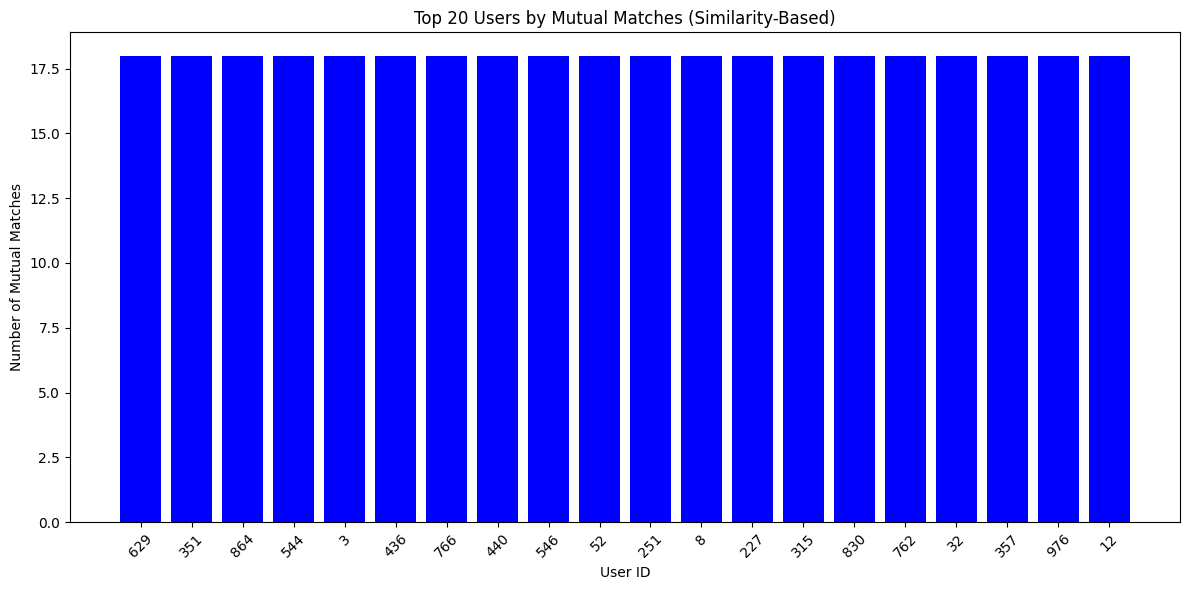

In [ ]:
# Count mutual matches per user
mutual_counts_sim = defaultdict(int)
for i, j in mutual_matches_sim:
    mutual_counts_sim[i] += 1
    mutual_counts_sim[j] += 1

# Sort and select top 20
sorted_sim = sorted(mutual_counts_sim.items(), key=lambda x: x[1], reverse=True)
top_users_sim = [u for u, count in sorted_sim[:20]]
top_counts_sim = [count for u, count in sorted_sim[:20]]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(top_users_sim)), top_counts_sim, tick_label=top_users_sim, color='blue')
plt.xlabel('User ID')
plt.ylabel('Number of Mutual Matches')
plt.title('Top 20 Users by Mutual Matches (Similarity-Based)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Interpreting the Similarity-Based Model

The similarity-based model produced the highest number of mutual matches by far (5,490), with the top 20 users all having similarly high match counts. This reflects a more inclusive and balanced model; one that emphasizes trait closeness rather than raw magnitude.

This result is expected, given that the model penalizes trait differences directly. As a result, small differences across key traits no longer disqualify potential matches and compatibility is based more closely on alignment.

To evaluate match quality more closely, we examine two sample users: User 3 and User 250. In contrast to earlier models, the similarity model returned matches that were consistently close across nearly all traits, especially in high-weighted categories like religion and education

In [ ]:

user_id = 3
print(f"\nTop {top_k} matches for User {user_id} (similarity-based): {top_matches_sim[user_id]}")
print("\nUser's own profile:")
print(df_clean.iloc[user_id])
print("\nSimilarity-based top match profiles:")
print(df_clean.iloc[top_matches_sim[user_id]])

user_id = 250
print(f"\nTop {top_k} matches for User {user_id} (similarity-based): {top_matches_sim[user_id]}")
print("\nUser's own profile:")
print(df_clean.iloc[user_id])
print("\nSimilarity-based top match profiles:")
print(df_clean.iloc[top_matches_sim[user_id]])


Top 10 matches for User 3 (similarity-based): [505, 436, 535, 254, 840, 766, 79, 554, 440]

User's own profile:
diet          3
drinks        4
smokes        0
education     9
body_type     2
pets         14
religion     20
Name: 3, dtype: int64

Similarity-based top match profiles:
     diet  drinks  smokes  education  body_type  pets  religion
505     3       4       0          9          2    14        19
436     3       4       0          9          2    14        19
535     3       4       0          9          1    14        19
254     3       4       0          9          1    12        20
840     3       4       0          9          1    14        19
766     3       4       0          9          4    14        19
79      3       4       0          9          4    14        21
554     3       4       0          9          4    14        21
440     3       4       0          9          2    14        22

Top 10 matches for User 250 (similarity-based): [951, 789, 301, 974, 386, 


### Match Quality for Sample Users

The similarity model produced highly interpretable matches for both users:

- **User 3** had top matches with identical or near-identical values across all traits, especially education (all = 9) and religion (19–22).
- **User 250** had top matches with religion values of 4 or 5 and education values between 9 and 11, closely reflecting their own profile.

These matches feel more “human” than those from earlier models which often paired users with large mismatches. This confirms that modeling trait closeness, not just value magnitude, leads to more realistic and interpretable results particularly when trait weights are also considered.

## Final Note

This notebook was developed in support of my AM50 project on modeling compatibility in online dating apps.

In the process, I occasionally used tools like Google Gemini, online resources and search engines to support idea development, debugging, and research but all modeling decisions, coding, and analysis were conducted independently and reflect my own understanding and learning throughout the project.


— Nyasha Runhare